<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_DCGAN_25GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

###Librerie Importate




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend

####Installazioni


In [ ]:
!pip install pyyaml h5py

###Preparazione e download delle immagini
Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [ ]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Colab/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Colab/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Colab/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Colab/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='float32')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='float32')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='float32')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='float32')
print("test maligni caricati")

Mounted at /content/drive
train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


###Aggiungo le Lables 
Aggiungo la lables a tutte le immagini 0 per un benigno e 1 per un maligno.
Concateno i set di train e di test e faccio uno shuffle delle dei tensori

In [ ]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [ ]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


#Shuffle
#s = np.arange(X_train.shape[0])
#np.random.shuffle(s)
#X_train = X_train[s]
#y_train = y_train[s]

#s = np.arange(X_test.shape[0])
#np.random.shuffle(s)
#X_test = X_test[s]
#y_test = y_test[s]

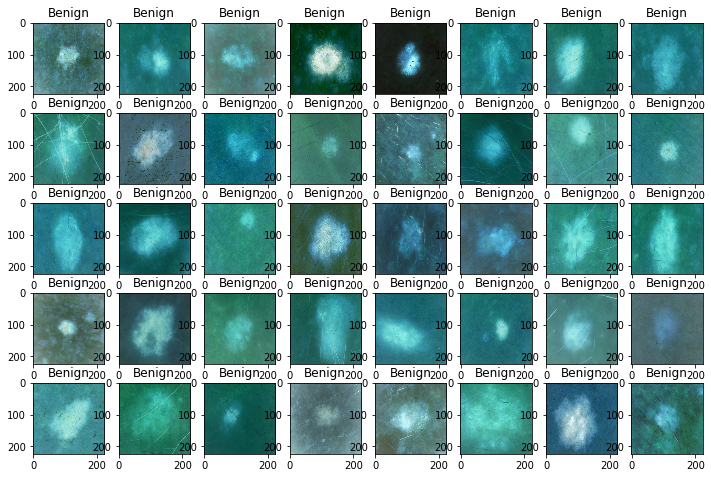

In [ ]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow((X_train[i] * 255).astype(np.uint8), interpolation='nearest')
plt.show()

###Lables Categoriche

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

###Normalizzo 

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape

(2637, 224, 224, 3)

###Costruisco il modello di addestramento

In [ ]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def Addestramento(input_shape, lr, numclassi, optim, activation_Dense): 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding = 'same',activation = 'relu', input_shape = input_shape,kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))#metto questo stato di dropout per evitare un overfitting della rete 
    model.add(layers.Conv2D(64, (3,3), padding = 'same' ,activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numclassi, activation='sigmoid'))
    #Scegli l'ottimizzatore
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
    return model
#-----------------------------------------------------------------------------------------------------------------------
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)
#-----------------------------------------------------------------------------------------------------------------------
def grafico(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']  
  val_loss = history.history['val_loss']
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.plot(epoches, val_acc, 'b', label ='Validation accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.plot(epoches, val_loss, 'b', label ='Validation loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()


Epoch 00009: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1e-07.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 

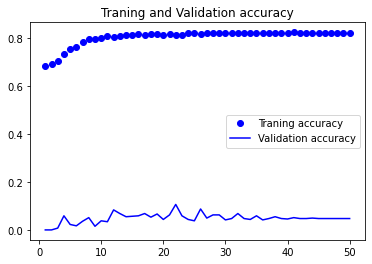

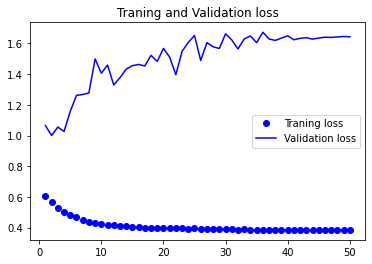

In [ ]:
model = Addestramento((224,224,3), 1e-5, 2,'relu', 'rmsprop')

epochs = 50
batch_size = 64

history = model.fit(X_train, y_train, validation_split=0.2, epochs= epochs ,
                    batch_size= batch_size,callbacks=[learning_rate_reduction], verbose=0)

model.summary()

grafico(history)

backend.clear_session()
del model
del history

###Cross-Validation

In [ ]:
#Merge inputs and targets
#inputs = np.concatenate((X_train, X_test), axis=0)
#targets = np.concatenate((y_train, y_test), axis=0)

inputs = X_train
targets = y_train

#shuffle è sempre cosa buona e giusta 
#tf.random.shuffle(X_train, seed=8)
#tf.random.shuffle(y_train, seed=8)

print(f'shape degli input = {inputs.shape}')
print(f'shape dei target = {targets.shape}')

#3 k fold
kfold = KFold(n_splits=3, shuffle=True)
print(f'values kfold = {kfold}')

#dove metto gli score
acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train, test in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    print(f'Rete n = {fold_no} in esecuzione')
    
    model = Addestramento((224,224,3), 1e-5, 2,'relu', 'rmsprop')
    
    #Addestro il modello su una parte dei dati di train
    model.fit(inputs[train], targets[train], epochs=epochs, batch_size=batch_size, verbose=0)
    
    #score del modello in percentuale
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score per fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1
    backend.clear_session()
    del model

#Media degli score
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Media degli scores per tutte le folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


shape degli input = (2637, 224, 224, 3)
shape dei target = (2637, 2)
values kfold = KFold(n_splits=3, random_state=None, shuffle=True)
------------------------------------------------------------------------
------------------------------------------------------------------------
Rete n = 1 in esecuzione
Score per fold 1: loss of 0.5430025458335876; accuracy of 69.16950941085815%
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
Rete n = 2 in esecuzione
Score per fold 2: loss of 0.47863540053367615; accuracy of 73.60637187957764%
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
---

###Testo il modello

In [ ]:
model = Addestramento((224,224,3), 1e-5, 2,'relu', 'rmsprop')

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=ReduceLROnPlateau(monitor = 'accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))
#print((model.predict(y_test) > 0.5).astype("int32"))


Epoch 00035: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.593939393939394


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CNN_rmsprop_sigmoid.h5') 

#DCGAN

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xn6o7d1a
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xn6o7d1a
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b5de8b6909eadaaa5c4854d80ed8e75afd3083a4_-cp36-none-any.whl size=146329 sha256=50ca56b7399256cd6e28466d96c8d7438b972ea15189760f1d470b153bf955de
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2l7xjnm/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
def make_generator_model_tensorflow(filter, kernel_size,):
    #kernel size (5,5) , filter 1 
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    model.summary()

    return model
def make_generator_model_mine(filter, kernel_size):
  #filter 3 kernrl_size (5,5)
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*16*16))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16,16,128)))
    model.add(layers.Conv2D(256, 5, padding = 'same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides = 2 , padding = 'same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, 5, padding = 'same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, 5, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(filter, kernel_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()

    return model
  




In [ ]:
generator = make_generator_model_mine(1, (5,5))

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

AttributeError: ignored